# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

import os
import math
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
import matplotlib.style as style
style.use('fivethirtyeight')

# Loading data

In [3]:
DATA_DIR = "data/"
DATASET_FILE = "Building_Permits.csv"

data_path = os.path.join(DATA_DIR, DATASET_FILE)
df = pd.read_csv(data_path)
df.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140.0,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1.380611e+12
1,201604195146,4,sign - erect,04/19/2016,0306,007,440.0,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1.420164e+12
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647.0,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1.424857e+12
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230.0,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1.443574e+12
4,201611283529,6,demolitions,11/28/2016,0342,001,950.0,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",1.445482e+11


# EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 43 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Permit Number                           198900 non-null  object 
 1   Permit Type                             198900 non-null  int64  
 2   Permit Type Definition                  198900 non-null  object 
 3   Permit Creation Date                    198900 non-null  object 
 4   Block                                   198900 non-null  object 
 5   Lot                                     198900 non-null  object 
 6   Street Number                           198900 non-null  int64  
 7   Street Number Suffix                    2216 non-null    object 
 8   Street Name                             198900 non-null  object 
 9   Street Suffix                           196132 non-null  object 
 10  Unit                                    2947

В данных большая часть фичей — категориальная. Также, ак можно заметить, в датасете очень много пропущенных данных (большинство признаков).

In [8]:
df.isna().sum().sort_values(ascending=False)

,0
TIDF Compliance,198898
Voluntary Soft-Story Retrofit,198865
Unit Suffix,196939
Street Number Suffix,196684
Site Permit,193541
Structural Notification,191978
Fire Only Permit,180073
Unit,169421
Completed Date,101709
Permit Expiration Date,51880


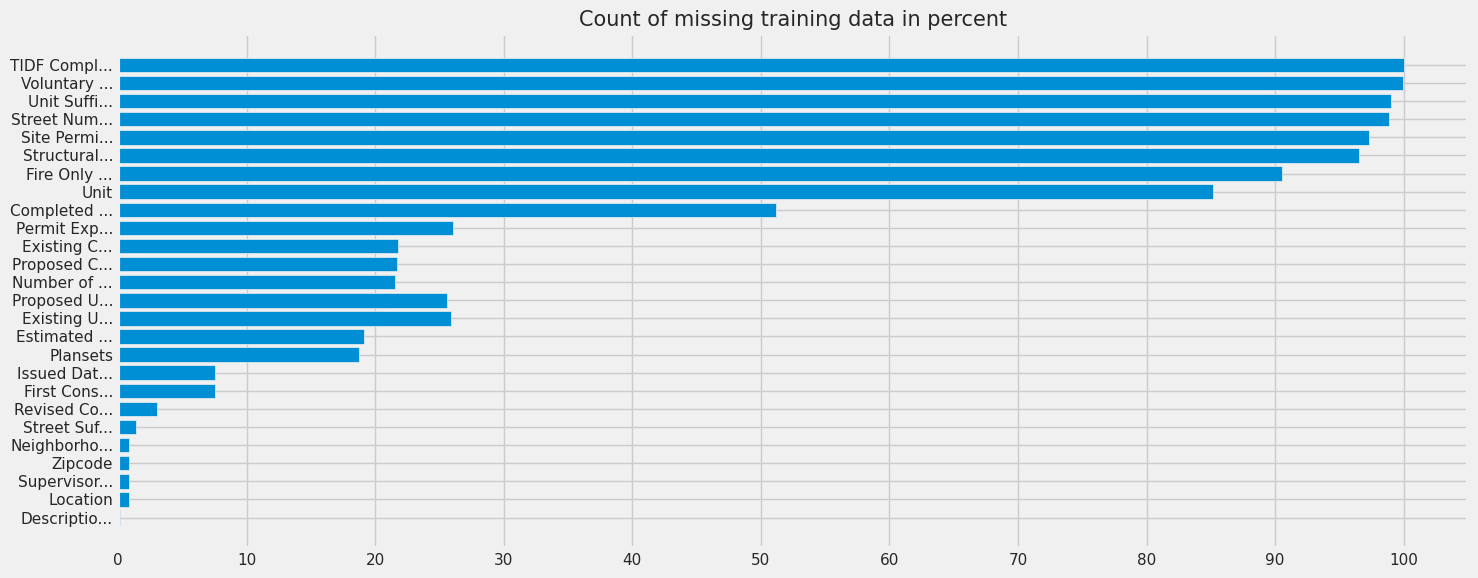

In [19]:
#@title
variables = df.columns

count = []

for variable in variables:
    length = df[variable].count()
    count.append(length)

count_pct = np.round(100 * pd.Series(count) / len(df), 2)
count = pd.Series(count)

missing = pd.DataFrame()
missing['variables'] = variables
missing['variables'] = missing['variables'].apply(lambda x: x[:10] + '...' if len(x) > 10 else x)
missing['count'] = len(df) - count
missing['count_pct'] = 100 - count_pct
missing = missing[missing['count_pct'] > 0]
missing.sort_values(by=['count_pct'], inplace=True)
missing_train = np.array(missing['variables'])

plt.subplots(figsize=(15,6))

plt.barh(missing['variables'], missing['count_pct'])
plt.title('Count of missing training data in percent', fontsize=15)

max_pct = missing['count_pct'].max()
xticks_pct = np.arange(0, max_pct + 10, 10)
plt.xticks(xticks_pct)

plt.tight_layout()
plt.show()

В случае, когда большая часть данных какого-то признака отсутствует, пропущенные данные уменьшают эффективный размер выборки. Каждая переменная "занимает" какую-то степень свободы. Если переменная имеет высокий процент пропущенных значений, она может не вносить значимого вклада в анализ, при этом уменьшая степени свободы для других переменных.

Для использования imputation, нам нужен очень большой объем выборки. Риск внесения смещения или шума (через imputation) перевешивает потенциальные преимущества сохранения переменной, если процент missing values больше, например, 50%.

Cтоит учитывать так же закономерности в пропусках. Есть 3 типа ([источник](https://stefvanbuuren.name/fimd/sec-MCAR.html)): MAR (missing at random), MCAR (missing completely at random), MNAR (missing NOT at random). [Ссылка](https://arxiv.org/pdf/2208.07813) на интересный способ определения MNAR.

В текущей работе отфильтруем все признаки, где пропущенных значений больше, чем 80% (по графику видно отсечку признаков).

In [4]:
missing_pct = df.isnull().mean() * 100

df = df.loc[:, missing_pct < 80]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15673 entries, 0 to 15672
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Permit Number                           15673 non-null  object 
 1   Permit Type                             15673 non-null  int64  
 2   Permit Type Definition                  15673 non-null  object 
 3   Permit Creation Date                    15673 non-null  object 
 4   Block                                   15673 non-null  object 
 5   Lot                                     15673 non-null  object 
 6   Street Number                           15672 non-null  float64
 7   Street Name                             15672 non-null  object 
 8   Street Suffix                           15475 non-null  object 
 9   Description                             15647 non-null  object 
 10  Current Status                          15672 non-null  ob

Удалили 8 признаков, которые могли значительно помешать при анализе!

# Поиск зависимостей

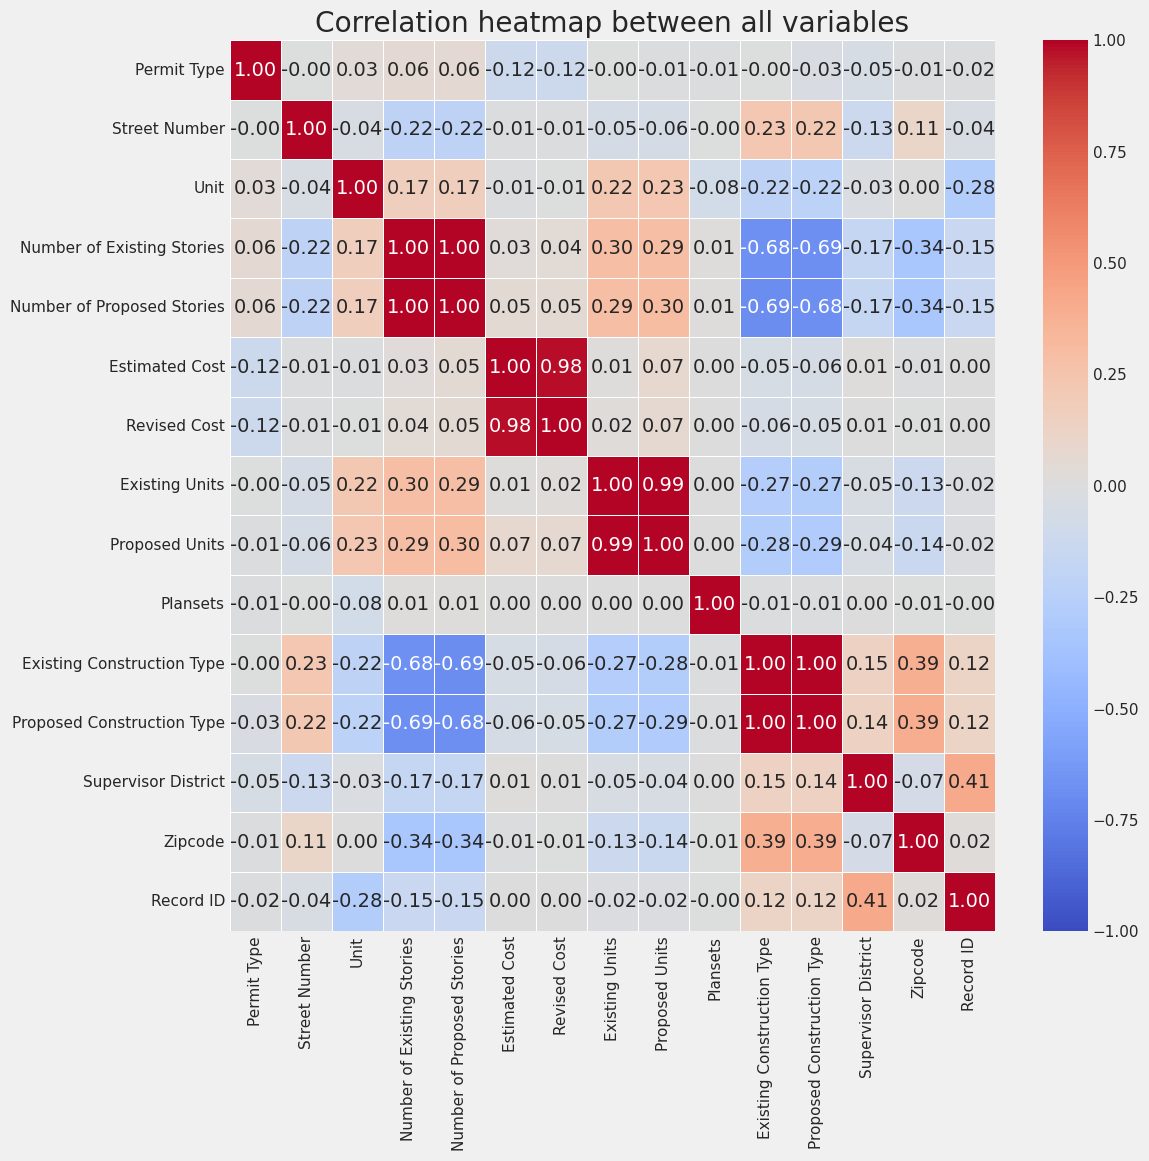

In [26]:
# @title
numerical_df = df.select_dtypes(include=[np.number])
corr_matrix = numerical_df.corr()

plt.figure(figsize=(11, 11))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation heatmap between all variables')
plt.show()

Можно выделить ряд признаков, которые почти "идеально" коррелируют друг с другом:
- proposed construction type и existing construction type
- existing units и proposed units
- revised cost и estimated cost
- number of proposed stories и number of existing stories
- number of existing stories и proposed construction type
- number of existing stories и existing construction type

Можно исключить следующие переменные: number of existing stories, proposed units, estimated cost, proposed construction type.

Статья, по которой корреляции > 0.7 обязательно надо устранять: Dormann, C. F., J. Elith, S. Bacher, et al. 2013. Collinearity: a review of methods to deal with it and a simulation study evaluating their performance. Ecography 36:27–46.

In [5]:
df.drop(columns=["Number of Existing Stories", "Proposed Units", "Estimated Cost", "Proposed Construction Type"], axis=1, inplace=True)

In [ ]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
results = []

for col1, col2 in combinations(categorical_cols, 2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    results.append({"Variable 1": col1, "Variable 2": col2, "Chi-Square": chi2_stat, "P-Value": p_value})

pd.DataFrame(results)

Не смогла запустить ячейку выше (ОЗУ исчерпывается), а очень жаль, ведь так хотелось посмотреть на зависимости в категориальных переменных((

In [6]:
numeric_df = df.select_dtypes(include=[np.number]).dropna()

numeric_df = numeric_df + 1e-10 # добавляем небольшое смещение для вычислений

vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

vif_data

,Feature,VIF
0,Permit Type,1.076840e+00
1,Street Number,1.105991e+00
2,Unit,1.168375e+00
3,Number of Proposed Stories,2.248926e+00
4,Revised Cost,1.040255e+00
5,Existing Units,1.373920e+00
6,Plansets,1.170713e+00
7,Existing Construction Type,2.322138e+00
8,Supervisor District,1.096225e+00
9,Zipcode,9.343986e-07


У всех этих переменных низкий (< 5) показатель мультиколлинеарности, что хорошо для моделирования зависимостей. При VIF > 10 стоило бы рассмотреть переменную к удалению.

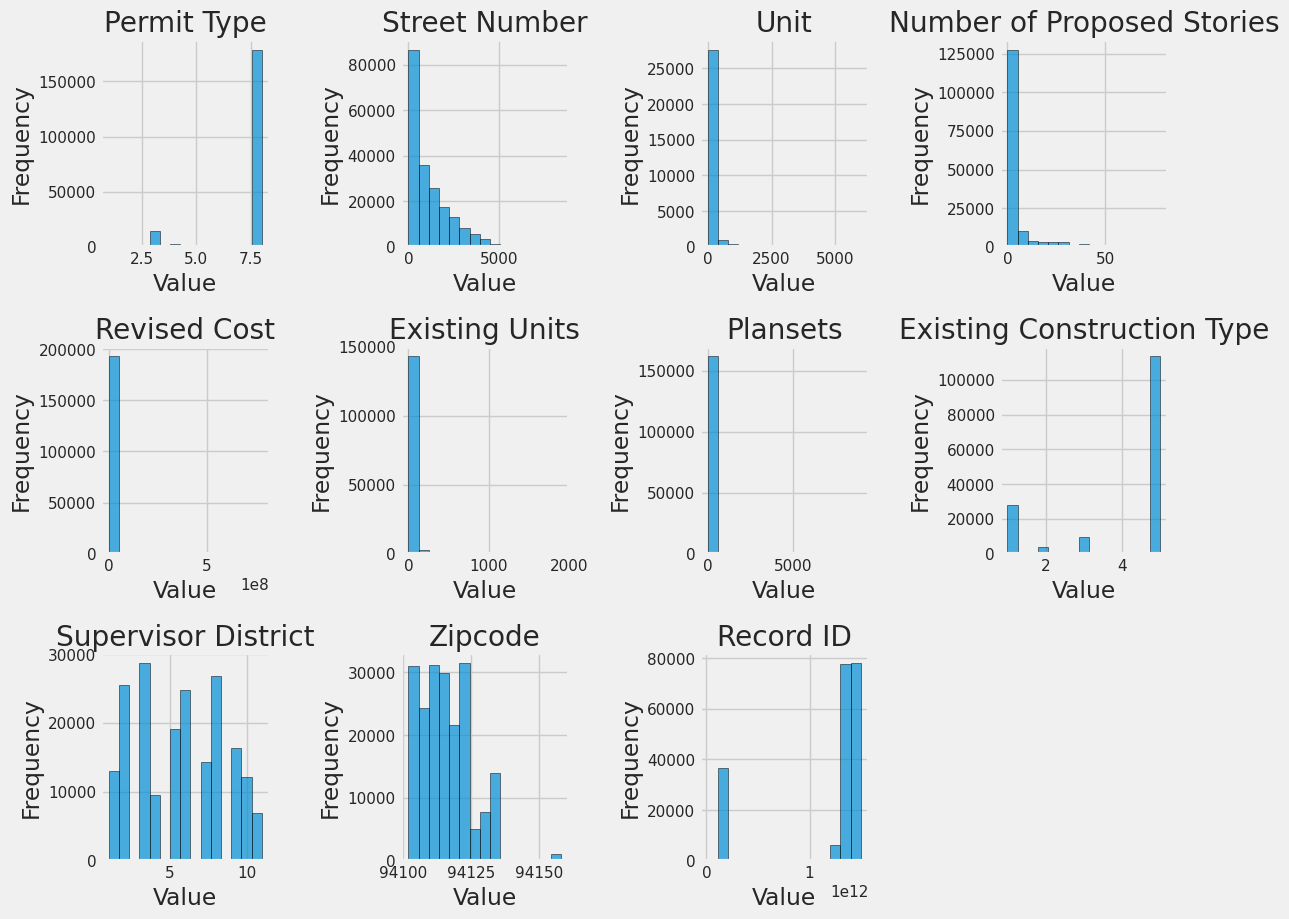

In [9]:
# @title
numeric_cols = numeric_df.columns
num_features = len(numeric_cols)

grid_size = int(np.ceil(np.sqrt(num_features)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col], bins=15, edgecolor="black", alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
numeric_df = df.select_dtypes(include=[np.number])
numeric_df.describe()

,Permit Type,Street Number,Unit,Number of Proposed Stories,Revised Cost,Existing Units,Plansets,Existing Construction Type,Supervisor District,Zipcode,Record ID
count,198900.000000,198900.000000,29479.000000,156032.000000,1.928340e+05,147362.000000,161591.000000,155534.000000,197183.000000,197184.000000,1.989000e+05
mean,7.522323,1121.728944,78.517182,5.745043,1.328562e+05,15.666164,1.274650,4.072878,5.538403,94115.500558,1.162048e+12
std,1.457451,1135.768948,326.981324,8.613284,3.584903e+06,74.476321,22.407345,1.585756,2.887041,9.270131,4.918215e+11
min,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,94102.000000,1.293532e+10
25%,8.000000,235.000000,0.000000,2.000000,1.000000e+00,1.000000,0.000000,3.000000,3.000000,94109.000000,1.308567e+12
50%,8.000000,710.000000,0.000000,3.000000,7.000000e+03,1.000000,2.000000,5.000000,6.000000,94114.000000,1.371840e+12
75%,8.000000,1700.000000,1.000000,4.000000,2.870750e+04,4.000000,2.000000,5.000000,8.000000,94122.000000,1.435000e+12
max,8.000000,8400.000000,6004.000000,78.000000,7.805000e+08,1907.000000,9000.000000,5.000000,11.000000,94158.000000,1.498342e+12


Несмотря на картинку на графиках, по таблице можно сказать, что все признаки имеют ненулевое стандартное отклонение, причем в большинстве случаев оно одного порядка со средним — значит, масштаб на графиках почти обманул, что несколько фичей практически неинформативны. Однако стоит заметить, что есть явно мусорные (неправильные) значения в данных — например, 0 в Revised Cost.

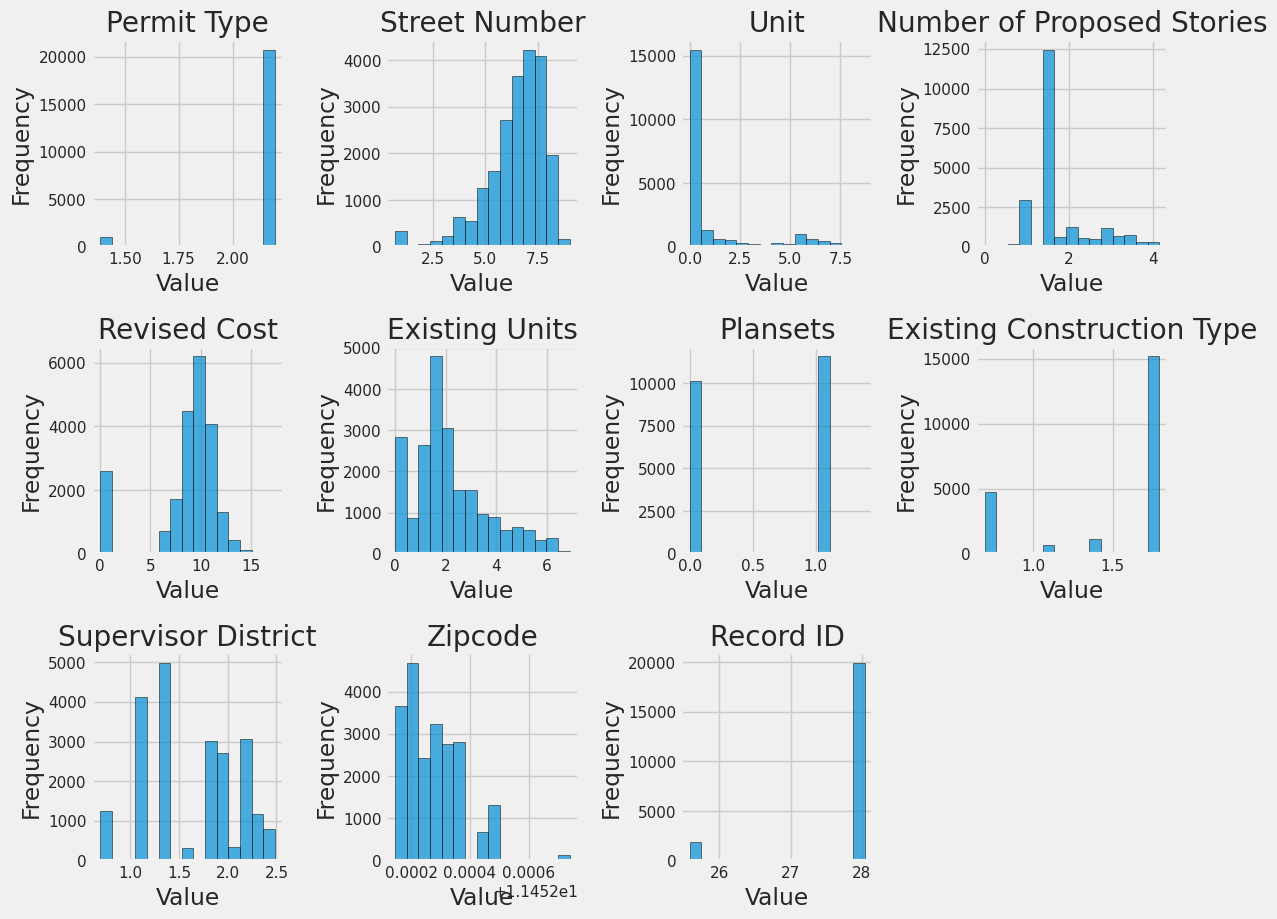

In [9]:
# @title
numeric_cols = numeric_df.columns
num_features = len(numeric_cols)
numeric_df[numeric_cols] = np.log1p(df[numeric_cols])

grid_size = int(np.ceil(np.sqrt(num_features)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(numeric_df[col], bins=15, edgecolor="black", alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Выводы про распределения после логарифмирования: Street numebr - распределение с положительным сдвигом (right-skewed), большинство значений сосредоточено в одном диапазоне. Unit - данные сильно скошены влево, большинство значений равно 0 или близко к нему. Number of proposed stories - большая часть распределения сосредоточена вокруг небольшого количества этажей. Видно преобладание проектов с малым числом этажей, что характерно для жилых зданий. Revised cost - почти нормальное распределение с небольшим левым сдвигом. Existing units - скошенное влево распределение, большинство зданий имеют небольшое количество существующих единиц. Plansets - бинарное распределение. Вероятно это признак наличия или отсутствия планов, с почти равномерным распределением. Existing Construction Type - наличие четко выраженного преобладающего значения, что говорит о доминировании одного типа конструкции. Supervisor District - категориальное распределение, равномерное распределение по различным районам. Zipcode - смещенное влево распределение, есть выбросы. Record ID - почти дискретное распределение с резким доминированием одного значения.

Посмотрим, какие из численных переменных на самом деле являются категориальными:

In [9]:
numeric_cols = df.select_dtypes(include=['number']).columns
unique_counts = df[numeric_cols].nunique()

potential_categoricals = unique_counts[unique_counts <= 100]

pd.DataFrame({
    "Column": potential_categoricals.index,
    "Unique_Values": potential_categoricals.values
}).reset_index(drop=True)

,Column,Unique_Values
0,Permit Type,8
1,Number of Proposed Stories,64
2,Plansets,7
3,Existing Construction Type,5
4,Supervisor District,11
5,Zipcode,27


Рассуждая логически, можно сделать вывод, что в следующих фичах нет отношения порядка: Permit Type, Plansets, Existing Construction Type, Supervisor District, Zipcode. Значит, можно сделать их категориальными.

In [6]:
cat_candidates = ["Permit Type", "Plansets", "Existing Construction Type", "Supervisor District", "Zipcode"]

for col in cat_candidates:
  df[col] = df[col].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   Permit Number                           198900 non-null  object  
 1   Permit Type                             198900 non-null  category
 2   Permit Type Definition                  198900 non-null  object  
 3   Permit Creation Date                    198900 non-null  object  
 4   Block                                   198900 non-null  object  
 5   Lot                                     198900 non-null  object  
 6   Street Number                           198900 non-null  int64   
 7   Street Name                             198900 non-null  object  
 8   Street Suffix                           196132 non-null  object  
 9   Description                             198610 non-null  object  
 10  Current Status                  

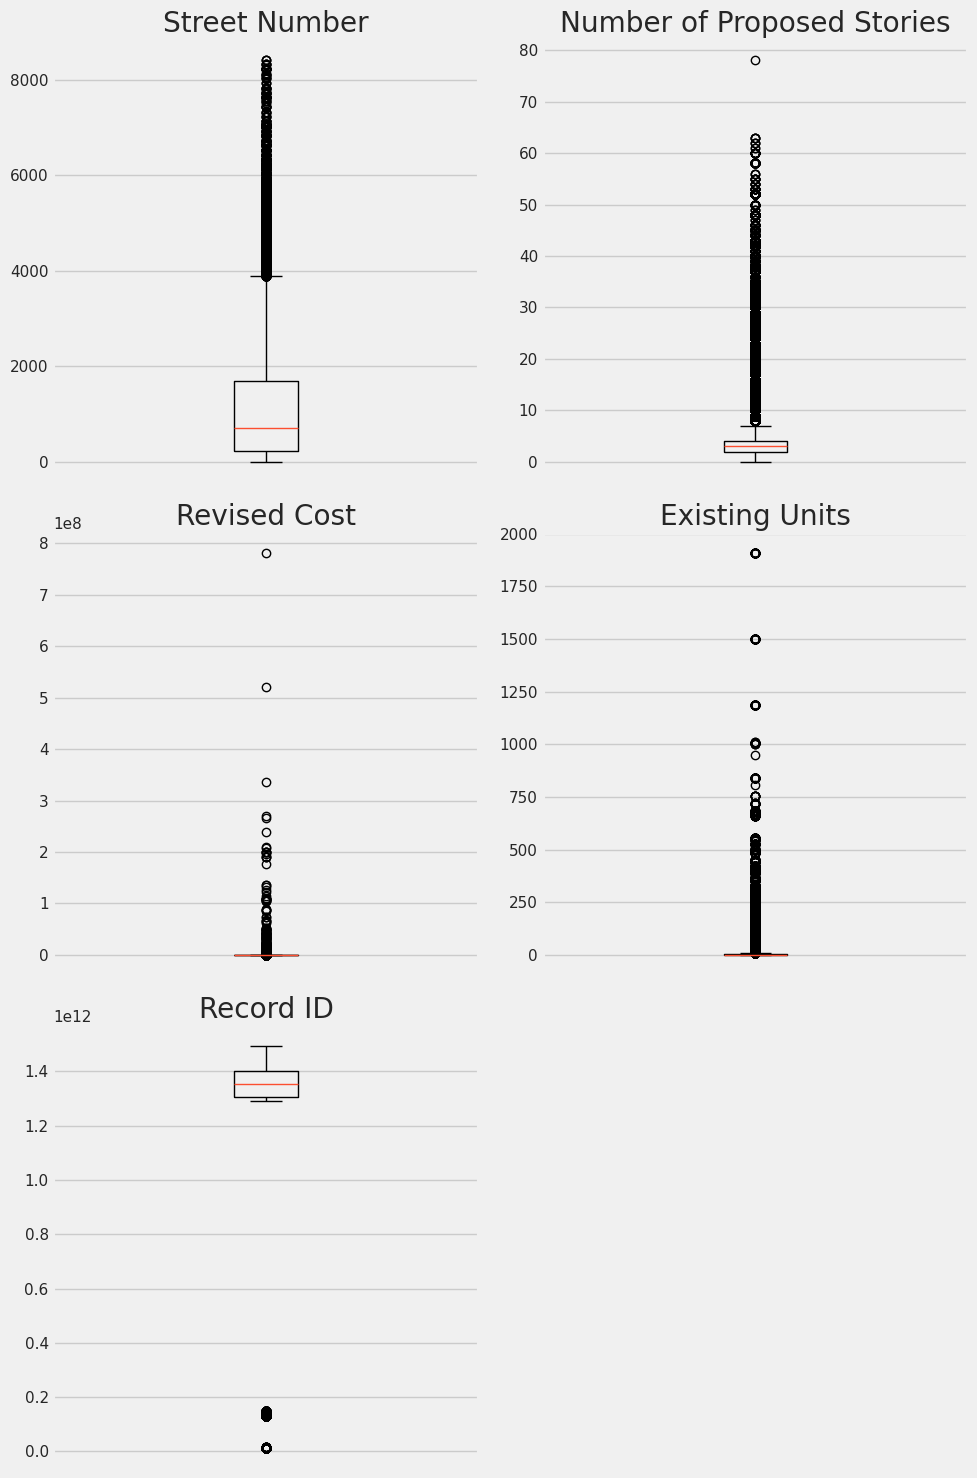

In [22]:
# @title
num_cols = df.select_dtypes(include=['number']).columns

cols = 2
num_features = len(num_cols)
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten() if num_features > 1 else [axes]

for i, col in enumerate(num_cols):
    axes[i].boxplot(df[col].dropna(), vert=True)
    axes[i].set_title(col)
    axes[i].set_xticks([])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Видно, что очень много выбросов. Их надо будет хорошо почистить.

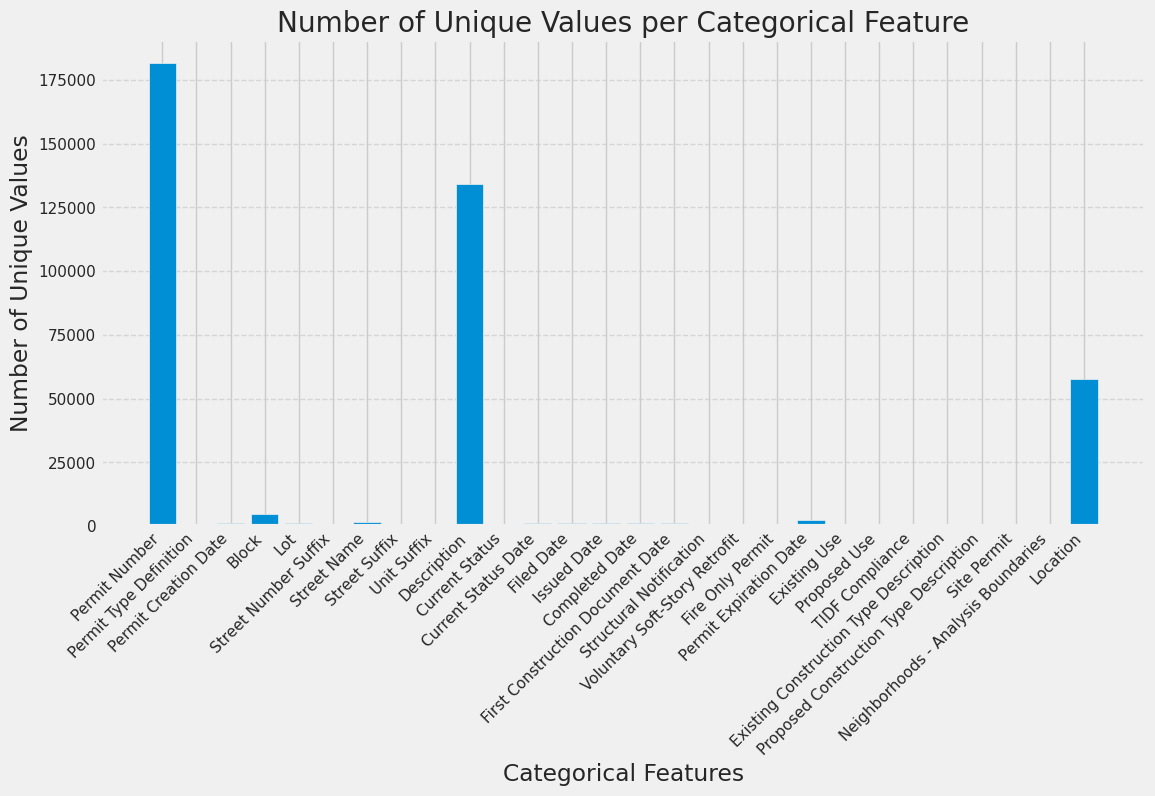

In [10]:
# @title
categorical_columns = df.select_dtypes(include=["object", "category"]).columns
unique_counts = df[categorical_columns].nunique()

plt.figure(figsize=(12, 6))
plt.bar(unique_counts.index, unique_counts.values)
plt.xlabel("Categorical Features")
plt.ylabel("Number of Unique Values")
plt.title("Number of Unique Values per Categorical Feature")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Я также пыталась построить графики для каждой категориальной фичи относительно value_counts(), но колаб тоже крашился(

Видим, что Permit Number - это фактически id объекта. Из-за масштаба не видно полной картины, исправим это.

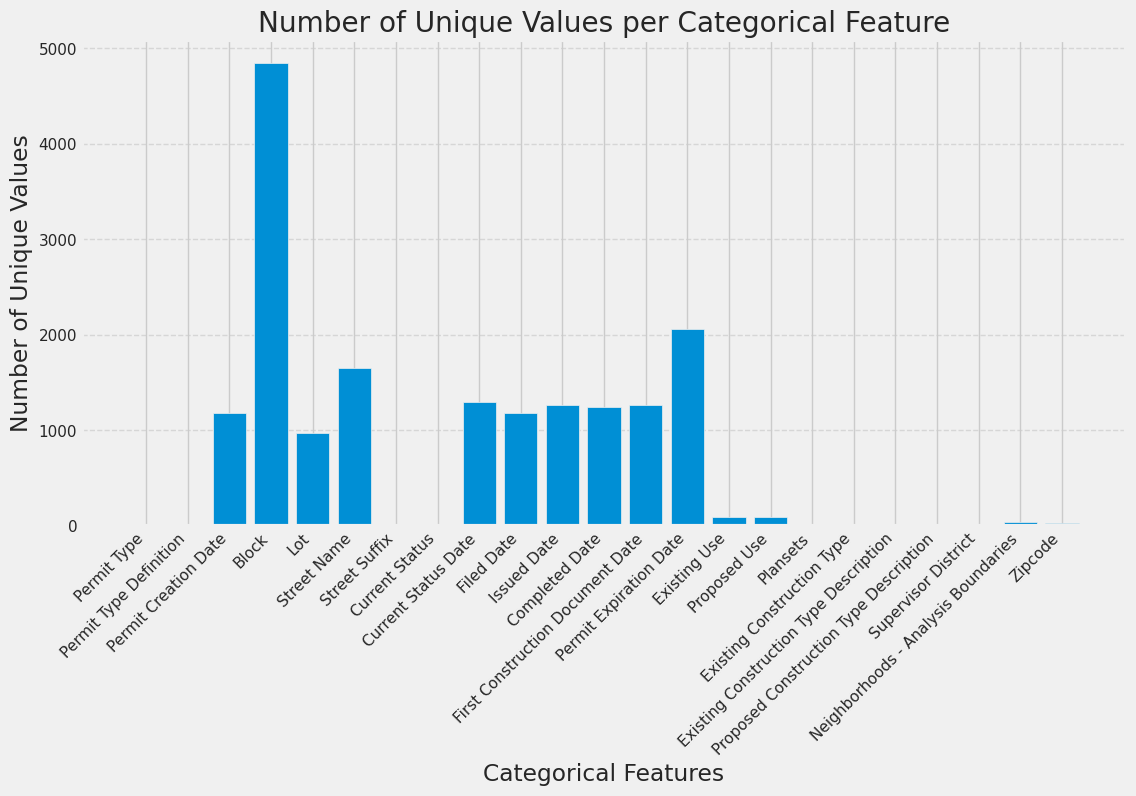

In [23]:
cut_df = df.drop(columns=["Permit Number", "Description", "Location"])

# @title
categorical_columns = cut_df.select_dtypes(include=["object", "category"]).columns
unique_counts = cut_df[categorical_columns].nunique()

plt.figure(figsize=(12, 6))
plt.bar(unique_counts.index, unique_counts.values)
plt.xlabel("Categorical Features")
plt.ylabel("Number of Unique Values")
plt.title("Number of Unique Values per Categorical Feature")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Какое моделирование доступно для этих данных и возможные верхнеуровневые задачи

Можно попробовать моделировать многие зависимости. Например:
1. Попробовать предсказать время выдачи разрешений для различных типов разрешений. Какие из них имеют большее значение?
2. Предложить, какой день недели лучше всего посещать Департамент строительных инспекций, основываясь на этих данных?
3. Сделать выводы о развитии города на основе этих данных
4. Провести кластерный анализ, попробова выделить дорогие и бедные районы
5. Сравнение активности в различных секторах строительства

Соответственно, для данных можно решать как проблему регрессии и классификации, так и кластеризации

Будем пытаться предсказать время выдачи разрешений.

# Data preprocessing

## Imputation

Волевым решением удалим признак Completed Date, тк там больше половины NaNов, а импутация здесь логически вносит слишком сильный bias.

In [6]:
df.drop(columns=["Completed Date"], axis=1, inplace=True)

In [7]:
df_cleaned = df.dropna(subset=['Issued Date'])

In [8]:
from collections import Counter
from sklearn.preprocessing import StandardScaler

def preprocess_dataset(df: pd.DataFrame, cat_threshold: float = 0.05) -> pd.DataFrame:
    df = df.copy()

    num_cols = df.select_dtypes(include=["number"]).columns
    cat_cols = df.select_dtypes(include=["object", "category"]).columns

    for col in num_cols:
        if df[col].isnull().all():
            continue

        q1, q3 = np.percentile(df[col].dropna(), [25, 75])
        iqr = q3 - q1
        lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), np.nan, df[col])

        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    for col in cat_cols:
        if df[col].isnull().all():
            continue

        most_frequent = df[col].mode()[0]
        df[col].fillna(most_frequent, inplace=True)

        freq_counts = Counter(df[col])
        total_count = len(df[col])
        threshold_count = cat_threshold * total_count

        df[col] = df[col].apply(lambda x: x if freq_counts[x] >= threshold_count else "Other")

    return df

In [13]:
df_cleaned["Issued Date"] = pd.to_datetime(df_cleaned["Issued Date"])

In [14]:
cleaned_df = preprocess_dataset(df_cleaned)

# Modeling

In [10]:
cleaned_df

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Name,Street Suffix,Description,...,Proposed Use,Plansets,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type Description,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,Other,0.0,Other,Other,Other,Other,-0.910887,Other,St,Other,...,1 family dwelling,0.760283,-0.858975,constr type 3,wood frame (5),-0.886485,Other,-1.499949,Other,0.002045
1,Other,0.0,Other,Other,Other,Other,-0.601764,Other,St,Other,...,1 family dwelling,0.760283,-0.858975,constr type 3,wood frame (5),-0.886485,Other,-1.499949,Other,0.002045
3,Other,0.0,otc alterations permit,Other,Other,Other,0.212260,Other,Av,Other,...,1 family dwelling,0.760283,0.512428,wood frame (5),wood frame (5),-0.886485,Other,-0.707366,Other,0.002045
4,Other,0.0,Other,Other,Other,001,-0.076255,Other,St,Other,...,1 family dwelling,0.760283,-0.858975,constr type 3,wood frame (5),0.165978,Other,-1.499949,Other,0.002045
5,Other,0.0,otc alterations permit,Other,Other,Other,-0.230816,Other,St,Other,...,apartments,0.760283,-2.230379,constr type 1,constr type 1,1.569263,Other,-0.933818,Other,0.002045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15667,Other,0.0,otc alterations permit,Other,Other,Other,2.980971,Other,St,Other,...,1 family dwelling,0.760283,0.512428,wood frame (5),wood frame (5),0.867621,Other,1.783610,Other,1.944607
15668,Other,0.0,otc alterations permit,Other,Other,Other,-0.601764,Other,St,street space,...,1 family dwelling,0.760283,0.512428,wood frame (5),wood frame (5),0.165978,Other,-0.707366,Other,0.002045
15669,Other,0.0,otc alterations permit,Other,Other,Other,1.082956,Other,St,Other,...,1 family dwelling,-1.315300,0.512428,wood frame (5),wood frame (5),-1.237307,Other,0.877801,Other,1.945119
15670,Other,0.0,otc alterations permit,Other,Other,Other,1.361167,Other,St,Other,...,1 family dwelling,-1.315300,0.512428,wood frame (5),wood frame (5),-1.588128,Other,0.651348,Other,0.002045


In [11]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


In [15]:
cleaned_df["Year"] = cleaned_df["Issued Date"].dt.year.astype(int)
cleaned_df.drop(columns=["Issued Date"], inplace=True)

Results Table:
              Model       MSE       MAE        R2
0  Lasso Regression  0.509394  0.268399 -0.000462
1          CatBoost  0.237987  0.164671  0.532588


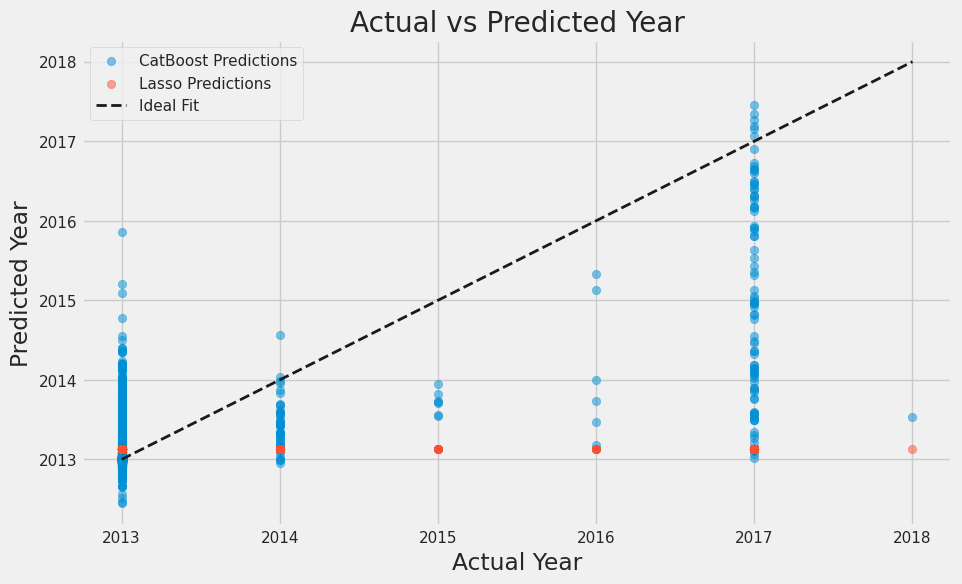

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

X = cleaned_df.drop('Year', axis=1)
y = cleaned_df['Year']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_cols),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_processed, y_train)
lasso_pred = lasso.predict(X_test_processed)

lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_mae = mean_absolute_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

cat_model = CatBoostRegressor(cat_features=categorical_cols, verbose=0)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)

cat_mse = mean_squared_error(y_test, cat_pred)
cat_mae = mean_absolute_error(y_test, cat_pred)
cat_r2 = r2_score(y_test, cat_pred)

results = pd.DataFrame({
    'Model': ['Lasso Regression', 'CatBoost'],
    'MSE': [lasso_mse, cat_mse],
    'MAE': [lasso_mae, cat_mae],
    'R2': [lasso_r2, cat_r2]
})

print("Results Table:")
print(results)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, cat_pred, alpha=0.5, label='CatBoost Predictions')
plt.scatter(y_test, lasso_pred, alpha=0.5, label='Lasso Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Year')
plt.ylabel('Predicted Year')
plt.title('Actual vs Predicted Year')
plt.legend()
plt.show()

## Обоснование:
Лассо-регрессия накладывает L1-регуляризацию, что может занулять коэффициенты некоторых признаков, тем самым отбирая наиболее важные. Однако Lasso может плохо работать на данных с нелинейными зависимостями, что может объяснять низкие результаты модели.

CatBoost – это модель градиентного бустинга, специально оптимизированная для работы с категориальными признаками и сложными нелинейными зависимостями. В нашем датасете очень много категориальных признаков, так что он хорошо подходит.

Выбор метрик (MSE, MAE, R²)

MSE метрика чувствительна к выбросам, так как квадратичная ошибка увеличивает влияние больших отклонений.

MAE показывает среднее отклонение предсказаний от фактических значений. Она менее чувствительна к выбросам, чем MSE, и даёт интерпретируемую среднюю ошибку. В нашем случае следует рассматривать эту метрику, так как много выбросов.

R² (коэффициент детерминации)
Этот показатель оценивает, насколько хорошо модель объясняет вариативность данных. Видно, что в случае регрессии модель работает хуже, чем наивное среднее.

Лассо регрессия:
MSE: 0.509
MAE: 0.268
R²: -0.000462 (практически 0, что указывает на неспособность модели объяснять данные)
модель не смогла уловить зависимости в данных, что может быть связано с нелинейностью таргета.

CatBoost:
MSE: 0.237
MAE: 0.164
R²: 0.532 (значительное улучшение по сравнению с лассо)
модель значительно лучше предсказывает таргет, что подтверждает ее хорошую способность работы с категориальными переменными.

# Бизнес-задача

Таргет -- это год, когда было выдано разрешение на строительство здания.
С помощью модели мы можем прогнозировать сроки выдачи разрешений для новых проектов. Потом использовать предсказания для оптимизации планирования строительства и управления ресурсами (например с точки зрения строительной/управляющей компании).
Бизнес-метрики:
Процент предсказаний, попадающих в допустимый интервал (например, ±1 год от реального значения).

Среднее время отклонения (насколько в среднем предсказания отклоняются от реальных сроков)

Экономический эффект (оценка того, как улучшение точности предсказаний влияет на бизнес-процессы (например, сокращение издержек или ускорение проектов)).